# Predikce výsledku bankovního telemarketingu

Popis úlohy:

Vybudovat klasifikační model, který na základě informací o zákazníkovi a telefonátu, rozhodne, jestli daný zákazník nabídku přijme nebo ne.

Zdroj dat:

https://archive.ics.uci.edu/dataset/222/bank+marketing

[Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

  Available at: [pdf] http://hdl.handle.net/1822/14838
                [bib] http://www3.dsi.uminho.pt/pcortez/bib/2011-esm-1.txt

## Předzpracování datasetu

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
rd_seed = 40

### Načtení datasetu a popis příznaků:

In [45]:
data = pd.read_csv("bank-full.csv", sep=';')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Data klienta banky:

- 0 - age = věk, numerický
- 1 - job = zaměstnání, kategorický: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services"
- 2 - marital = rodinný stav, kategorický: "married","divorced","single"; 
  - pozn: "divorced" znamená rozvedený nebo ovdovělý
- 3 - education = vzdělání - kategorický:  "unknown","secondary","primary","tertiary"
- 4 - default = nesplacený úvěr - "yes","no"
- 5 - balance = zůstatek - průměrný roční zůstatek v eurech - numerický
- 6 - housing = hypotéka - má hypotéku  "yes", "no"
- 7 - loan = půjčka - má osobní půjčku "yes", "no" 

Vztahující se k poslednímu kontaktu aktuální kampaně:

- 8 - contact = kontakt - způsob kontaktování - kategorický: "unknown", "telephone", "cellular"
- 9 - day = den - den posledního kontaktu, den v měsíci - numerický
- 10 - month = měsíc - měsíc posledního kontatku -  kategorický: "jan", "feb", "mar", ..., "nov", "dec"
- 11 - duration = délka - délka trvání rozhovoru v sekundách

Další příznaky:

- 12 - campaign - počet kontaktování během této kampaně pro konkrétního klienta - numerický
- 13 - pdays - počet dnů od posledního kontaktování během předchozí kampaně - numerický, -1 == klient nebyl kontaktován
- 14 - previous - počet kontaktování provedené před současnou kampaní
- 15 - poutcome - výsledek předchozí kampaně, kategorický: "unknown","other","failure","success"

Vysvětlovaná proměnná: 
- 16 - y - podepsal klient termínovaný vklad "yes", "no"

Neznáme hodnoty jsou v datasetu značeny hodnotou unknown

### Rozdělení dat na trénovací, validační a testovací množinu

In [46]:
def splitData(data, y_collumn):
    Xdata = data.drop(y_collumn, axis=1)
    ydata = data[y_collumn]
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        Xdata, ydata, test_size=0.3, random_state=rd_seed
    )
    Xval, Xtest, yval, ytest = train_test_split(
        Xtest, ytest, test_size=0.5, random_state=rd_seed
    )
    return Xtrain, ytrain, Xval, yval, Xtest, ytest

Xtrain, ytrain, Xval, yval, Xtest, ytest = splitData(data, 'y')

In [47]:
display(Xtrain.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
23363,31,management,single,tertiary,no,347,yes,no,cellular,27,aug,59,6,-1,0,unknown
7144,43,management,married,unknown,no,5172,yes,no,unknown,29,may,57,3,-1,0,unknown
31982,34,management,married,tertiary,no,1116,yes,no,cellular,13,apr,120,1,262,5,failure
11389,38,management,married,tertiary,yes,-1007,yes,yes,unknown,19,jun,71,1,-1,0,unknown
22242,34,management,single,tertiary,no,0,no,no,cellular,21,aug,129,4,-1,0,unknown


### Analýza kategorických příznaků

Před samotnou analýzou nejprve převedu na textový kód měsíce na odpovídající číslo 1-12. Potom všechny sloupce typu object převedu na categorický typ.

In [48]:
def to_cat(data):
    for column in data.columns:
        if data[column].dtype == object:
            data[column] = data[column].astype("category")
    return data

def map_months(data):
    month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    data['month'] = data['month'].map(month_mapping)
    return data

In [49]:
Xtrain = map_months(Xtrain)
Xtrain = to_cat(Xtrain)

Pro všechny kategorické příznaky vykreslím sloupcové grafy zobrazující počet jednotlivých kategoríí v daném sloupci.

In [53]:
def countplot_format(data, col):
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.countplot(x=col, data=data, edgecolor='black')
    plt.title(f'Count of {col}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

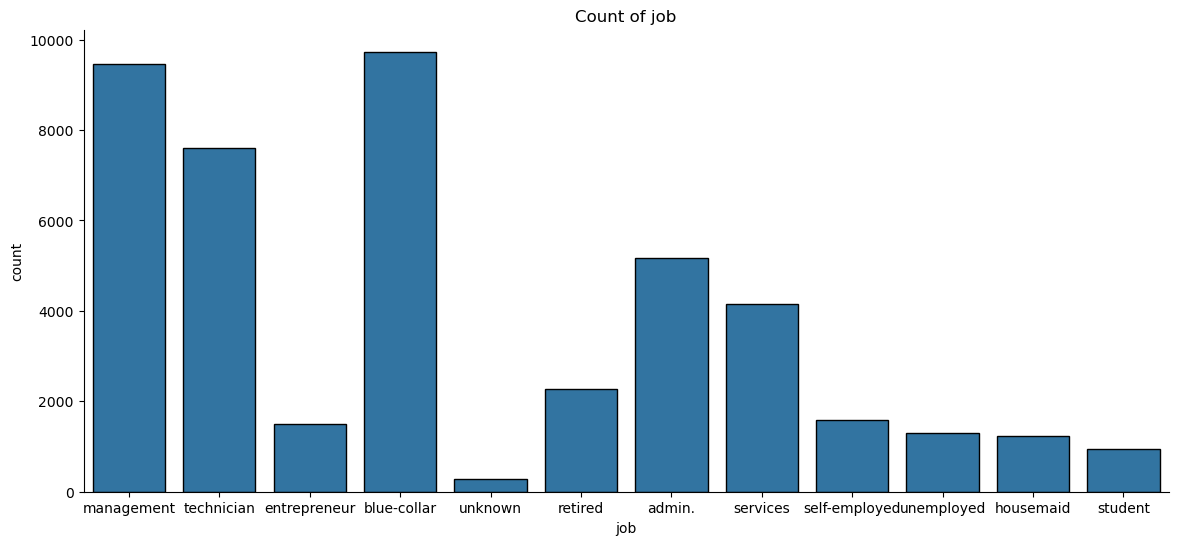

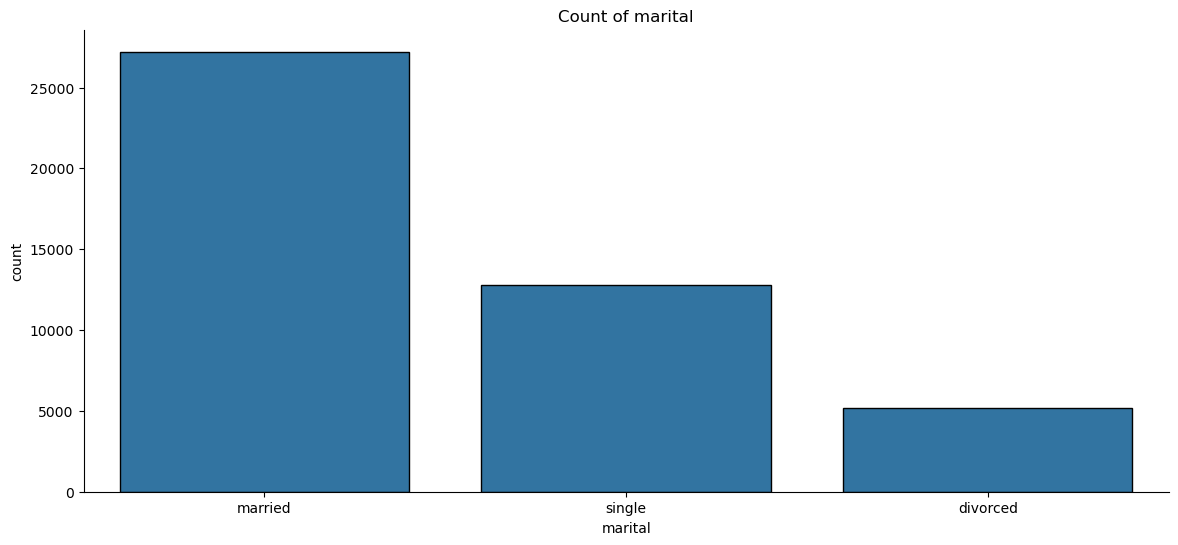

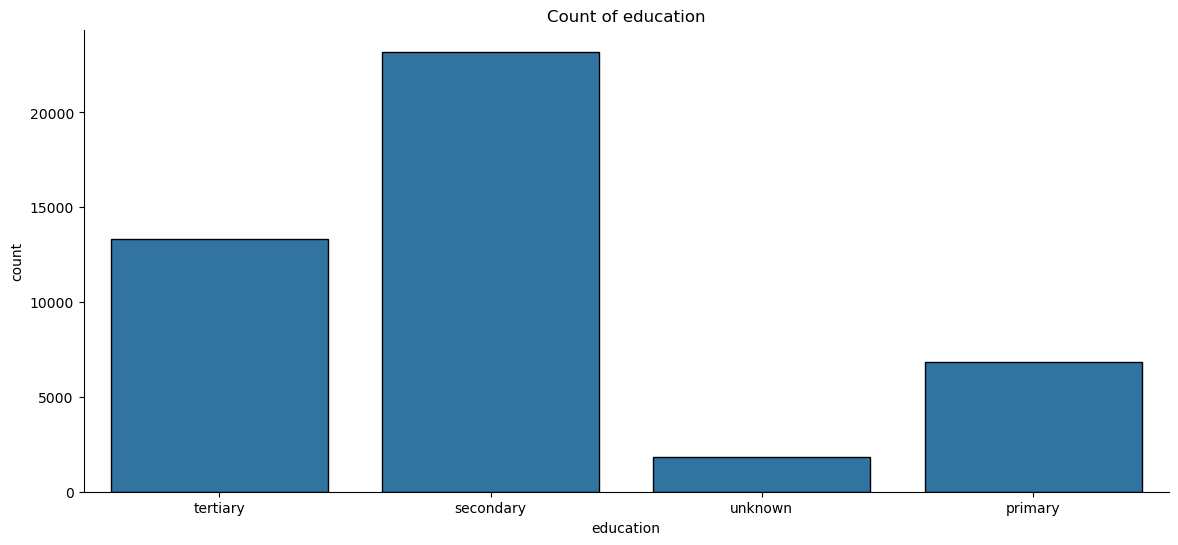

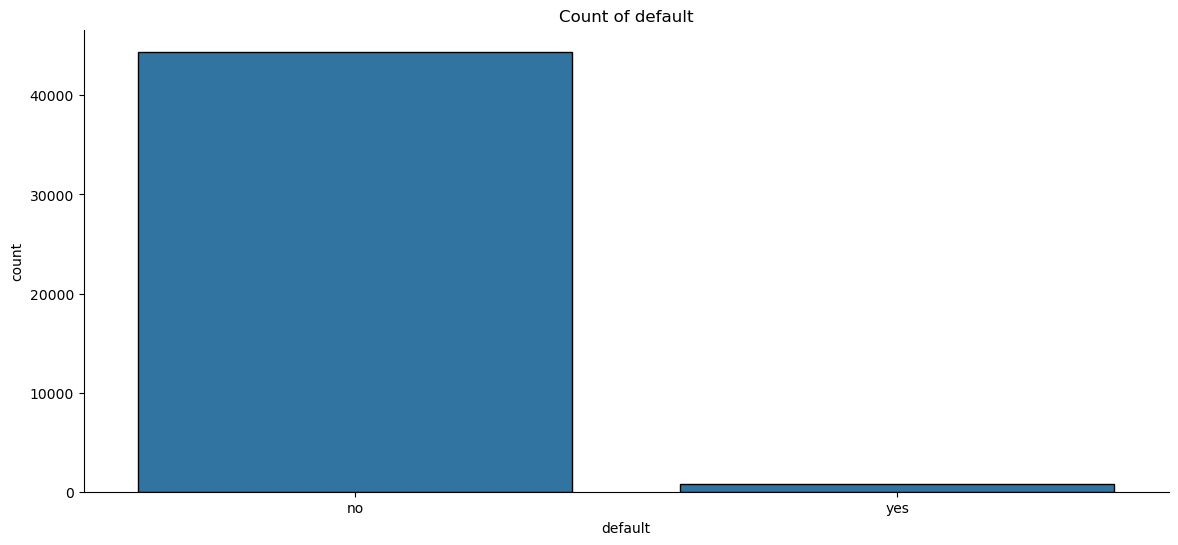

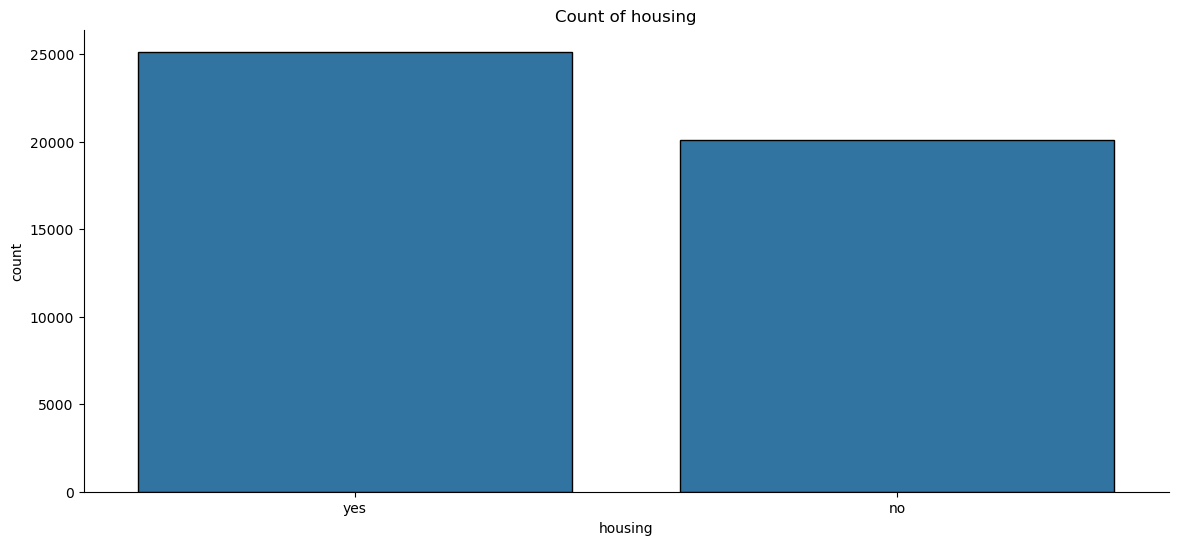

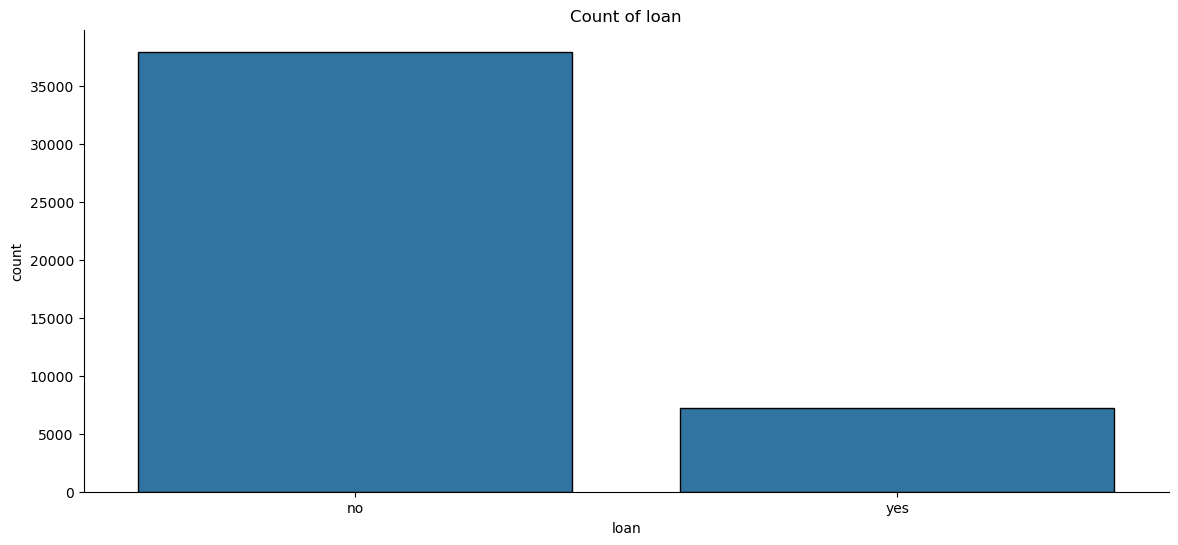

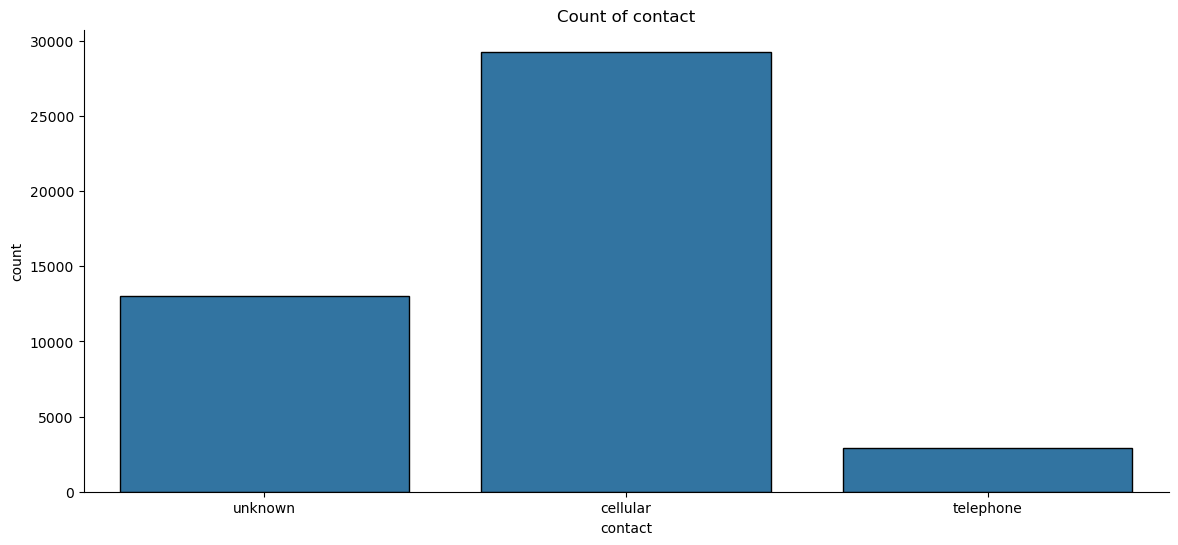

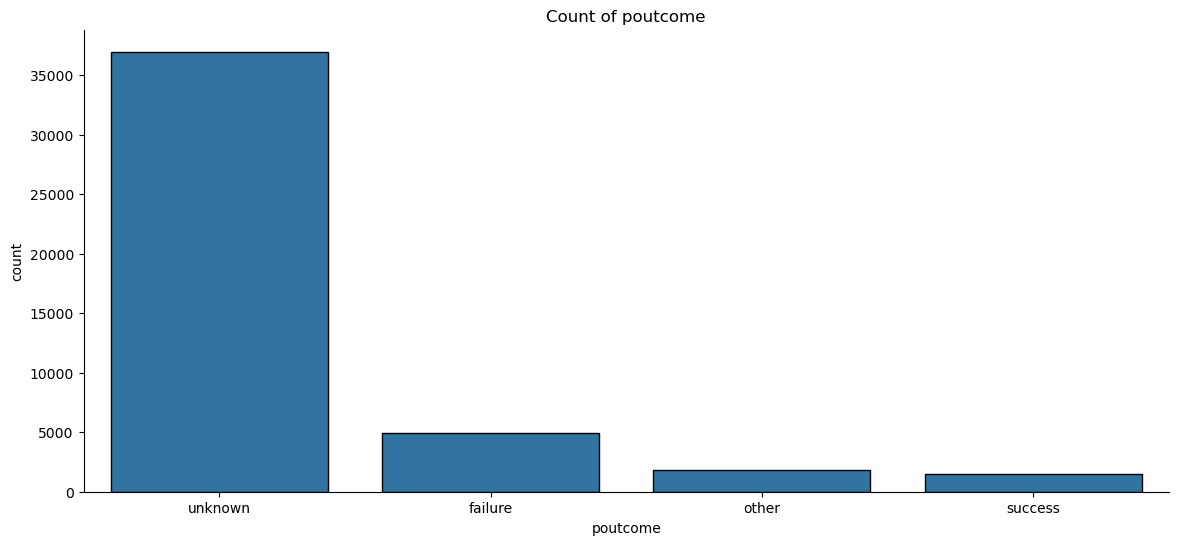

In [54]:
for column in Xtrain.columns:
    if pd.api.types.is_categorical_dtype(Xtrain[column]):
        countplot_format(data, column)

### Analýza numerických příznaků

In [55]:
def hist_box(df, cont_col, bins):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

    sns.histplot(df[cont_col], bins=bins, kde=False, ax=ax[0])
    ax[0].set_title(f"{cont_col.capitalize()} Distribution in Dataset")
    ax[0].set_xlabel(cont_col.capitalize())
    ax[0].set_ylabel("Frequency")

    sns.boxplot(x=df[cont_col], ax=ax[1])
    ax[1].set_title(f"Box Plot of {cont_col.capitalize()} in Dataset")
    ax[1].set_xlabel(cont_col.capitalize())

    plt.tight_layout()
    plt.show()
    display(df[cont_col].describe())

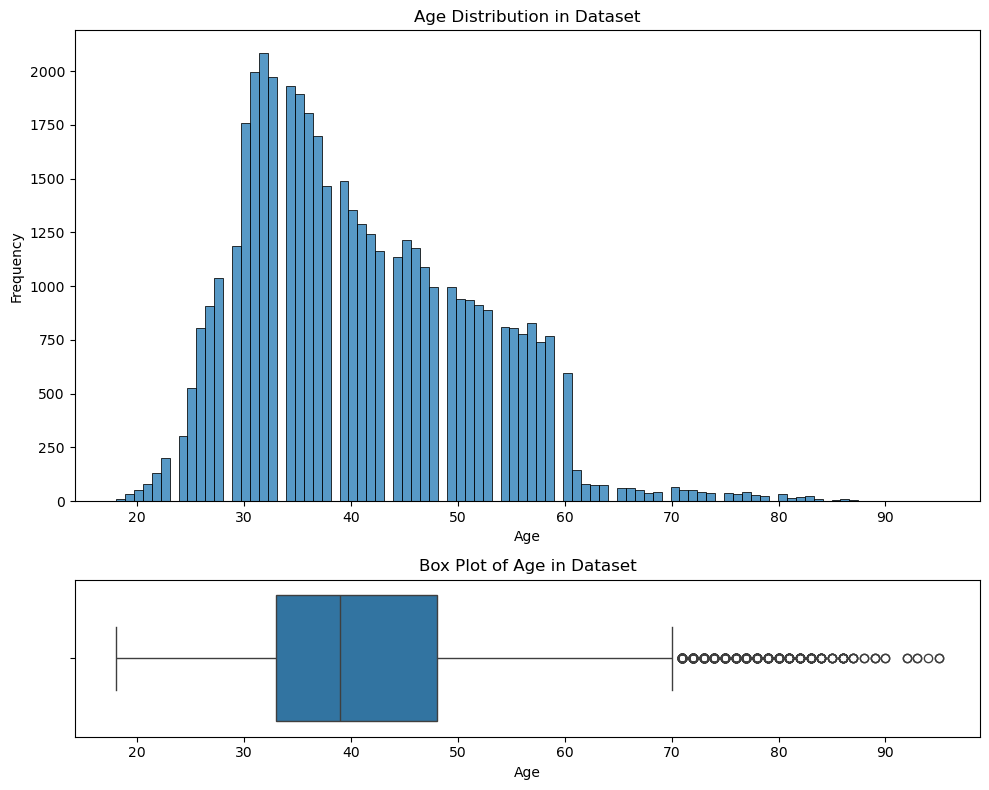

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

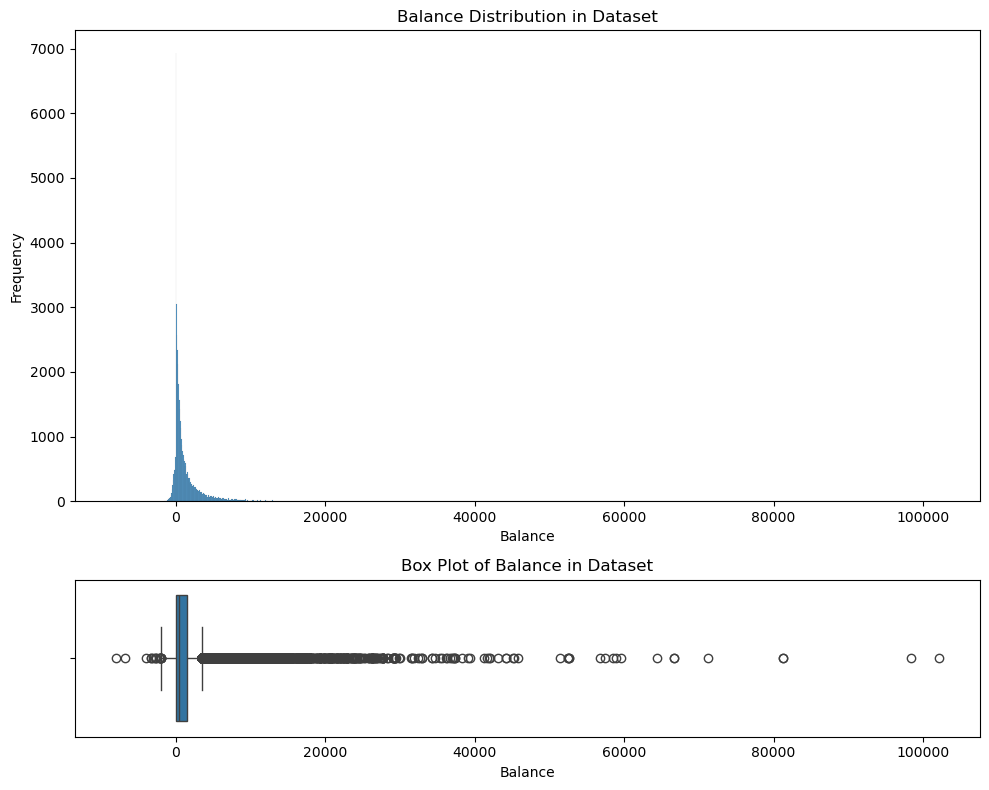

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

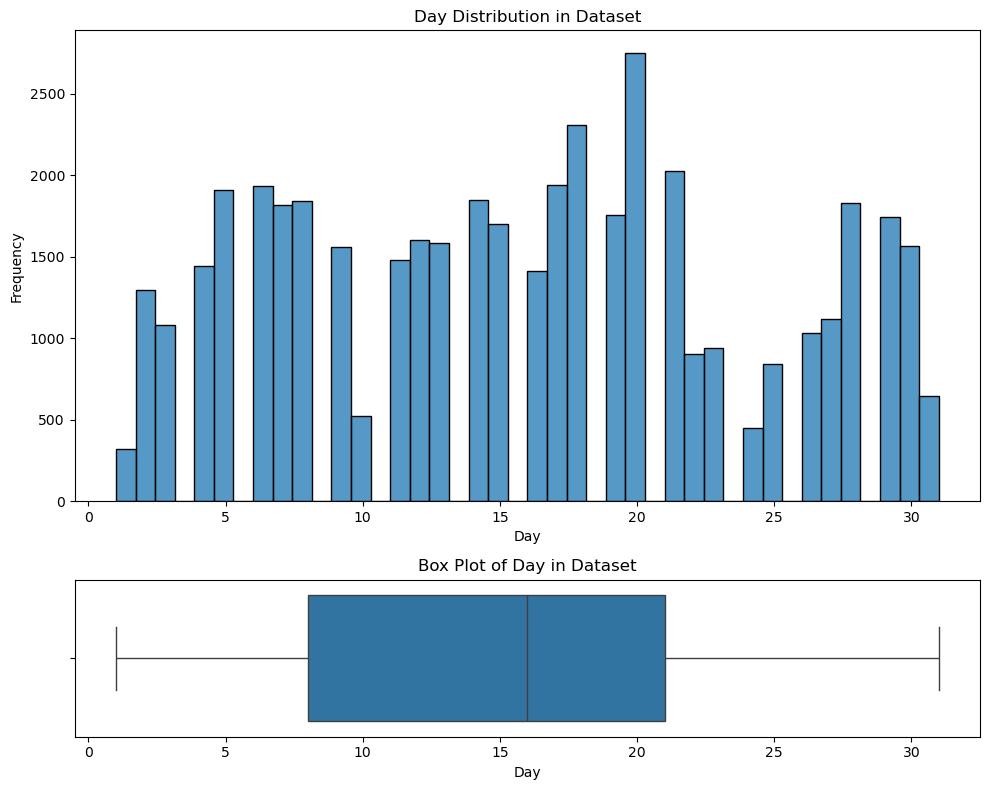

count    45211.000000
mean        15.806419
std          8.322476
min          1.000000
25%          8.000000
50%         16.000000
75%         21.000000
max         31.000000
Name: day, dtype: float64

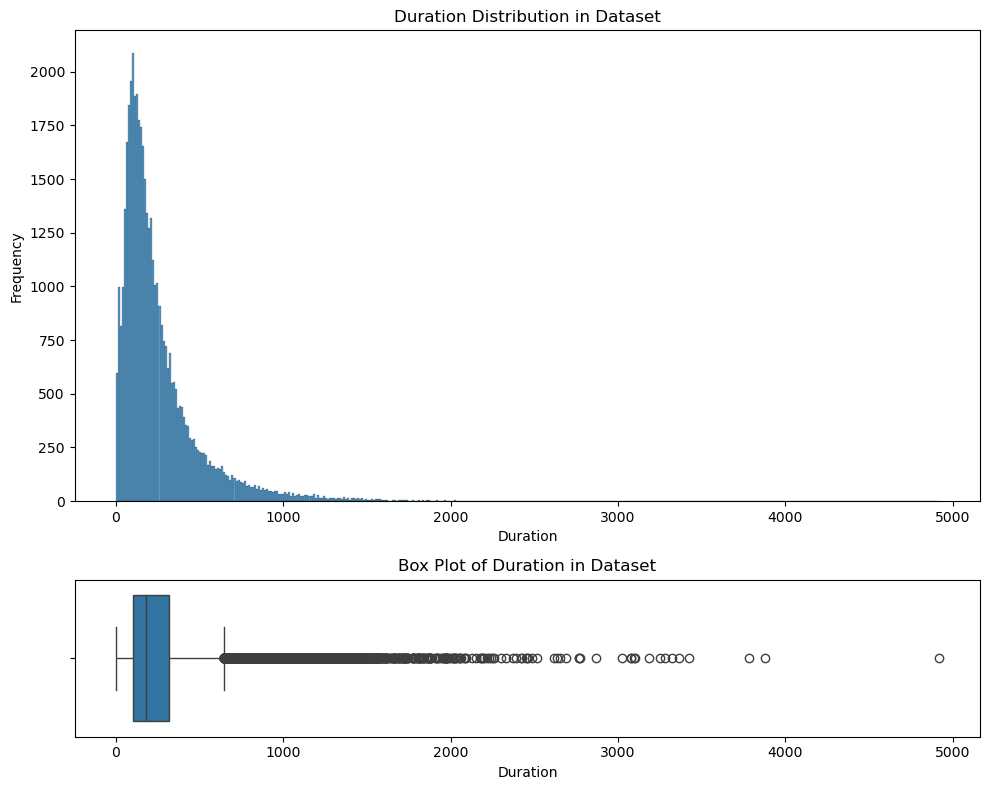

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

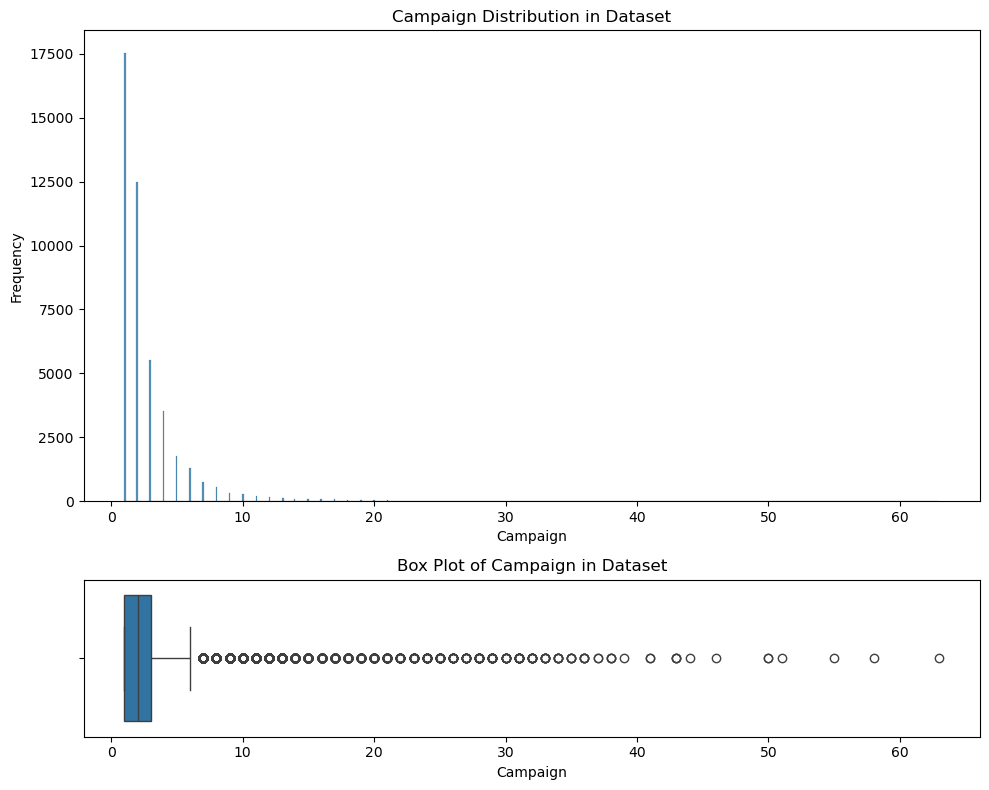

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

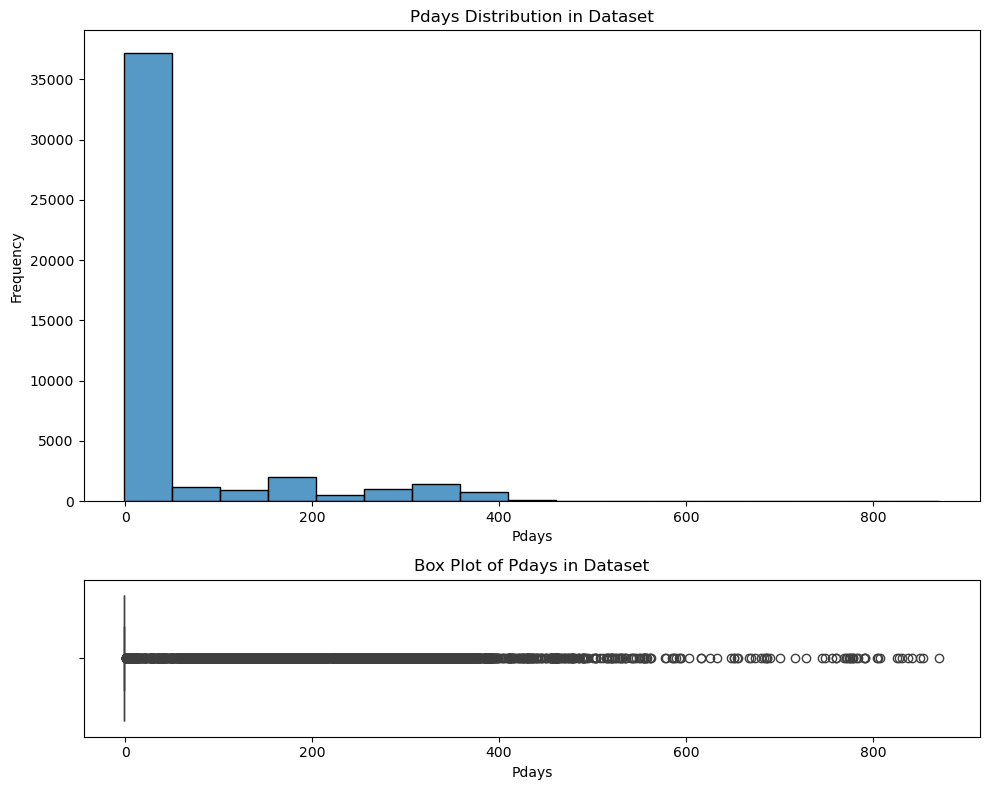

count    45211.000000
mean        40.197828
std        100.128746
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

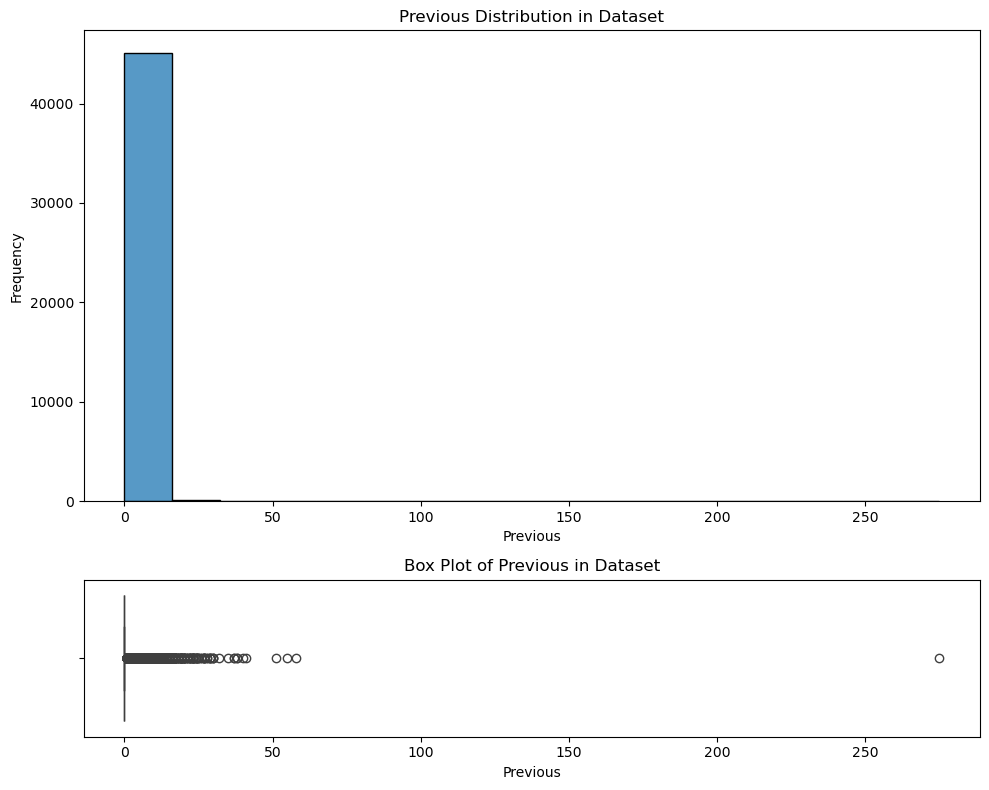

count    45211.000000
mean         0.580323
std          2.303441
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: previous, dtype: float64

In [56]:
for column in data.columns:
    if data[column].dtype == np.int64:
        hist_box(data, column, 'auto')

Všechny číselné hodnoty, jsou ve správných rozsazích. Nechybí žádné hodnoty.

### Transformace dat

In [58]:
def preprocess_data(train_df, val_df, test_df, colsToDrop=[]):
    datasets = [train_df, val_df, test_df]
    for i in range(len(datasets)):
        if (not datasets[i].empty):
            datasets[i] = datasets[i].drop(columns=colsToDrop)
            datasets[i] = map_months(datasets[i])
            datasets[i] = to_cat(datasets[i])

    train_df, val_df, test_df = datasets
    return train_df, val_df, test_df

In [ ]:
Xtrain, ytrain, Xval, yval, Xtest, ytest = splitData(data, 'y')
Xtrain, Xval, Xtest = preprocess_data(Xtrain, Xval, Xtest)